## Time Series Analysis Models - ARIMA

In [1]:
# Import related libraries

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from pmdarima.arima import auto_arima

In [2]:
# Import data

data = yf.Ticker('GOOG')
data = data.history(period= 'max')
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2004-08-19 00:00:00-04:00,2.490664,2.591785,2.390042,2.499133,897427216,0.0,0.0
2004-08-20 00:00:00-04:00,2.515820,2.716817,2.503118,2.697639,458857488,0.0,0.0
2004-08-23 00:00:00-04:00,2.758411,2.826406,2.716070,2.724787,366857939,0.0,0.0
2004-08-24 00:00:00-04:00,2.770615,2.779581,2.579581,2.611960,306396159,0.0,0.0
2004-08-25 00:00:00-04:00,2.614201,2.689918,2.587302,2.640104,184645512,0.0,0.0
...,...,...,...,...,...,...,...
2023-04-03 00:00:00-04:00,102.669998,104.949997,102.379997,104.910004,20719900,0.0,0.0
2023-04-04 00:00:00-04:00,104.839996,106.099998,104.599998,105.120003,20377200,0.0,0.0
2023-04-05 00:00:00-04:00,106.120003,106.540001,104.101997,104.949997,21864200,0.0,0.0


In [3]:
# Add a column representing the change in closing price

data['Last Day Closing Price'] = data['Close'].shift(1)
data['Close Change'] = data['Close'] - data['Last Day Closing Price']

data.drop(['Dividends', 'Stock Splits', 'Last Day Closing Price'], axis= 1, inplace= True)

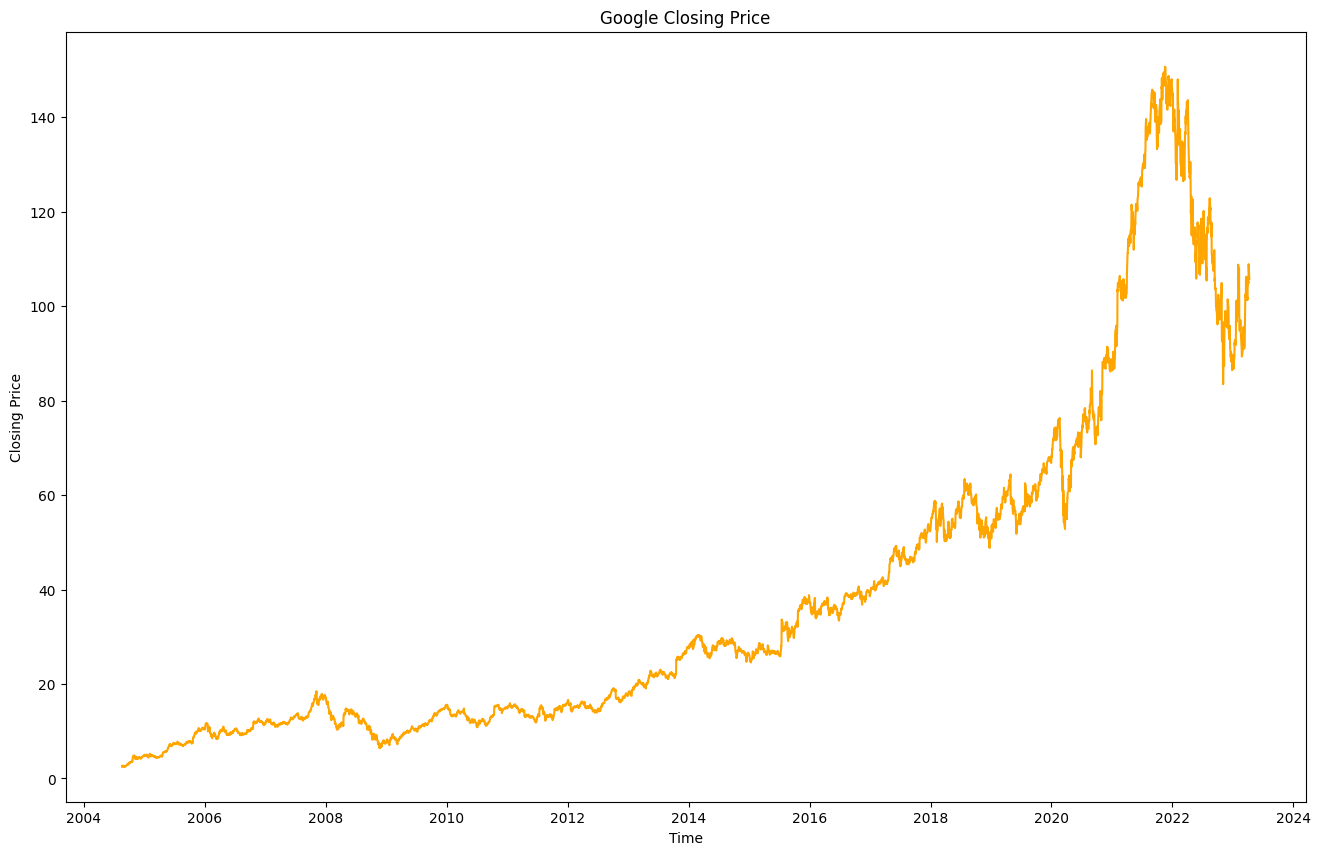

In [4]:
plt.figure(figsize= (16,10))
plt.title('Google Closing Price')
plt.plot(data['Close'], color= 'orange', label= 'Closing Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

We can see that the closing price of Google has witnessed a greater increase after 2015 as compared to the preceding years. Thus, I'm selecting the data from 2015 to put in the model.

In [5]:
# Find the earliest dates that the Google stock market opens in 2015

data = data.reset_index()
data[data['Date'].dt.strftime('%Y').str.contains('2015')]

,Date,Open,High,Low,Close,Volume,Close Change
2611,2015-01-02 00:00:00-05:00,26.378078,26.490770,26.133251,26.168653,28951268,-0.079283
2612,2015-01-05 00:00:00-05:00,26.091366,26.144720,25.582764,25.623152,41196796,-0.545502
2613,2015-01-06 00:00:00-05:00,25.679497,25.738087,24.983908,25.029282,57998800,-0.593870
2614,2015-01-07 00:00:00-05:00,25.280592,25.292759,24.914099,24.986401,41301082,-0.042881
2615,2015-01-08 00:00:00-05:00,24.831326,25.105074,24.482782,25.065184,67071641,0.078783
...,...,...,...,...,...,...,...
2858,2015-12-24 00:00:00-05:00,37.477501,37.567501,37.331001,37.419998,10544000,-0.095501
2859,2015-12-28 00:00:00-05:00,37.646000,38.149502,37.476002,38.125500,30306000,0.705502
2860,2015-12-29 00:00:00-05:00,38.334499,38.999001,38.321499,38.830002,35300000,0.704502
2861,2015-12-30 00:00:00-05:00,38.830002,38.880001,38.345001,38.549999,25866000,-0.280003


In [6]:
# Select data from 2015 until the most recent one

data = data.loc[2611:]
data

,Date,Open,High,Low,Close,Volume,Close Change
2611,2015-01-02 00:00:00-05:00,26.378078,26.490770,26.133251,26.168653,28951268,-0.079283
2612,2015-01-05 00:00:00-05:00,26.091366,26.144720,25.582764,25.623152,41196796,-0.545502
2613,2015-01-06 00:00:00-05:00,25.679497,25.738087,24.983908,25.029282,57998800,-0.593870
2614,2015-01-07 00:00:00-05:00,25.280592,25.292759,24.914099,24.986401,41301082,-0.042881
2615,2015-01-08 00:00:00-05:00,24.831326,25.105074,24.482782,25.065184,67071641,0.078783
...,...,...,...,...,...,...,...
4687,2023-04-03 00:00:00-04:00,102.669998,104.949997,102.379997,104.910004,20719900,0.910004
4688,2023-04-04 00:00:00-04:00,104.839996,106.099998,104.599998,105.120003,20377200,0.209999
4689,2023-04-05 00:00:00-04:00,106.120003,106.540001,104.101997,104.949997,21864200,-0.170006
4690,2023-04-06 00:00:00-04:00,105.769997,109.629997,104.815002,108.900002,34684200,3.950005


In [7]:
# Create a function checking the stationarity of the data

def stationarity_check(station_data):
    # Calculate rolling mean and standard deviation
    roll_mean = station_data.rolling(30, center= True, closed= 'both').mean()
    roll_std = station_data.rolling(10, center= True, closed= 'both').std()
    
    # Plot data, rolling mean and standard deviation
    fig = plt.figure(figsize= (16,10))
    plt.subplot(211)
    plt.plot(station_data, color= 'green', label= 'Original Data')
    plt.plot(roll_mean, color= 'black', label= 'Rolling Mean (30 days)')
    plt.legend()
    plt.subplot(212)
    plt.plot(roll_std, color= 'orange', label= 'Rolling Std (10 days)')
    plt.legend()
    plt.show()
    
    # Perform Augmented Dickey-Fuller test
    result = adfuller(station_data.dropna(), autolag= 'AIC')
    print('Dickey-Fuller test results\n')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for cv, r in result[4].items():
        print('\t%s: %.3f' % (cv, r))

### ARIMA for Closing Price

In [8]:
# Extract necessary data

close = data['Close']

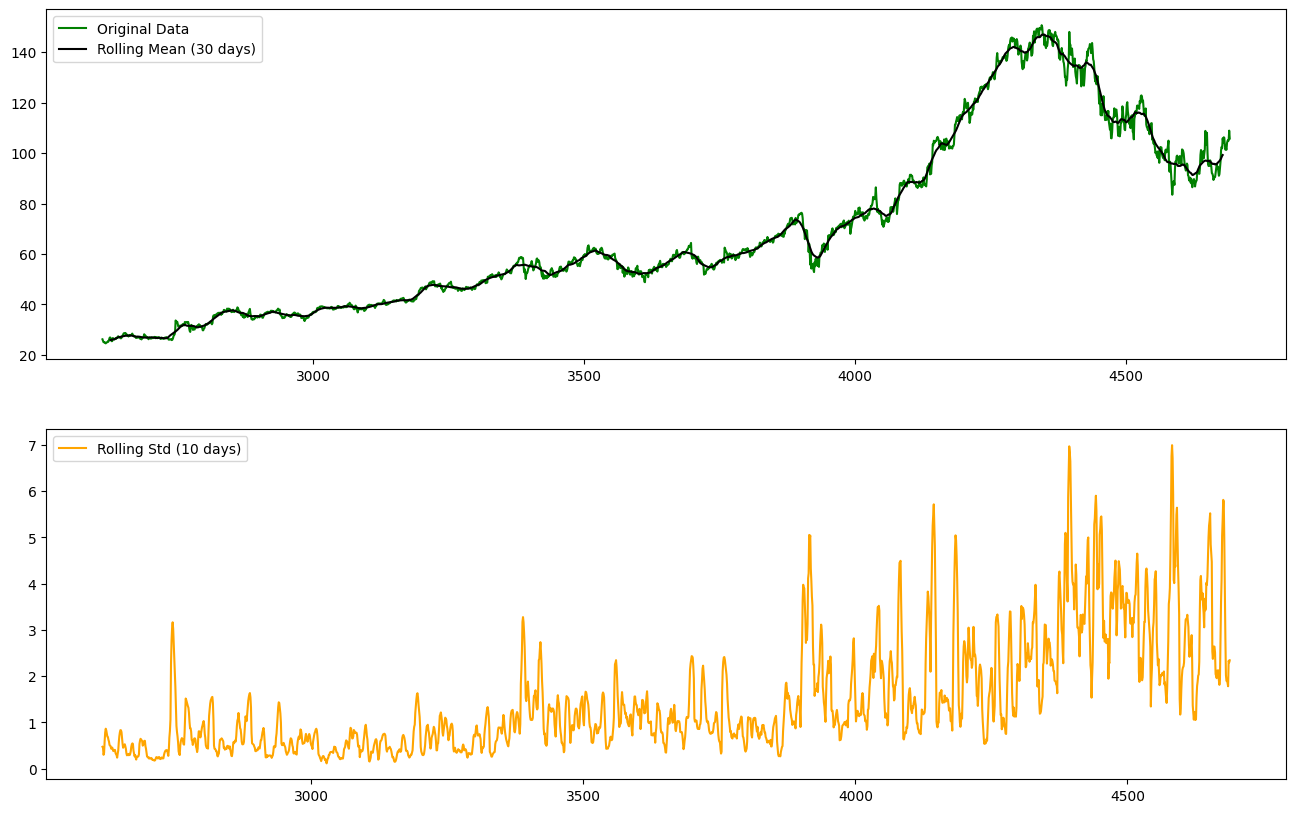

Dickey-Fuller test results

ADF Statistic: -0.9006636486672415
p-value: 0.7877537900719522
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [9]:
stationarity_check(close)

Original data is not stationary, let's try differencing it.

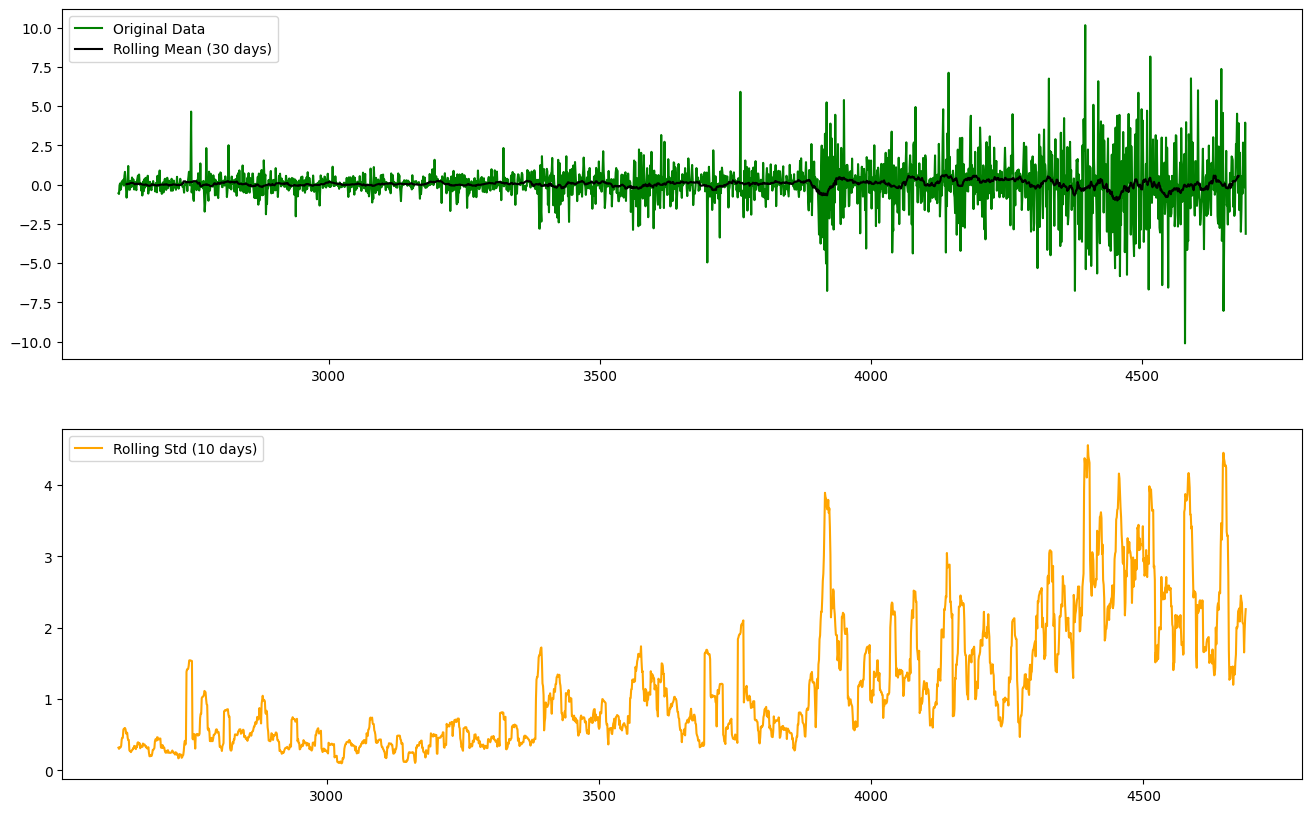

Dickey-Fuller test results

ADF Statistic: -11.001487460603824
p-value: 6.665027264853158e-20
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [10]:
close_diff = close.diff().dropna()
stationarity_check(close_diff)

Differencing by 1 shows the data is stationary, d = 1. With d = 1, let's begin ACF and PACF plot to find the optimal q and p parameter, respectively.

C:\Users\Admins\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


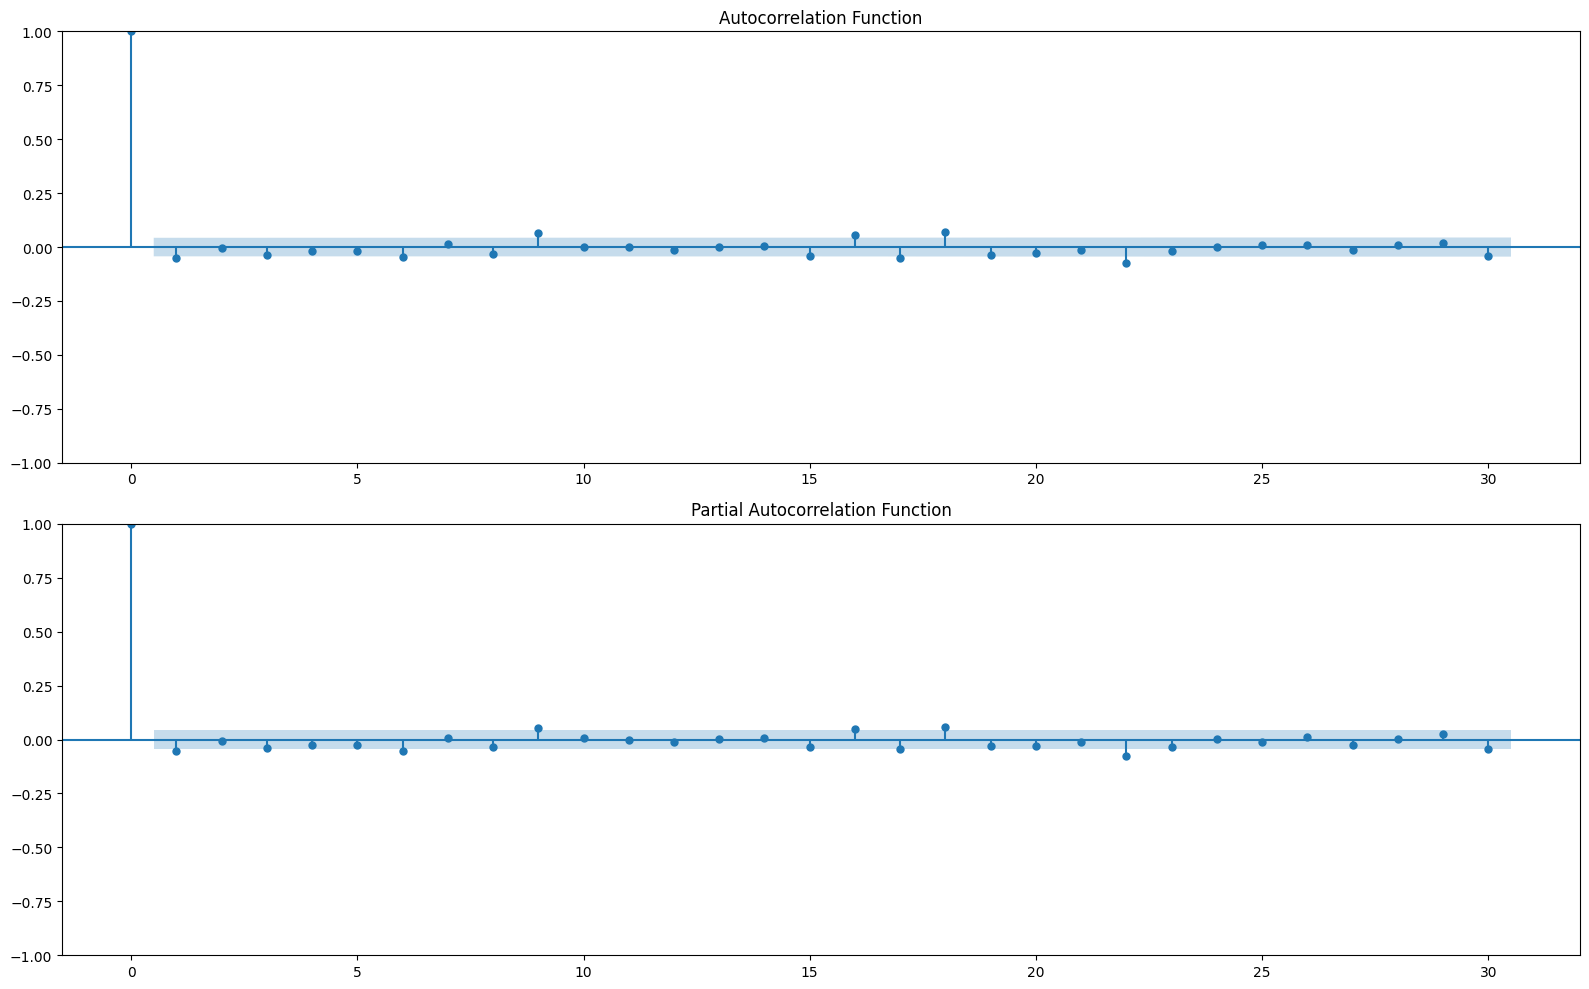

In [11]:
# Plot ACF and PACF functions

fig, ax = plt.subplots(2, figsize= (16, 10))
plot_acf(close_diff, ax= ax[0], lags= 30)
ax[0].set(title='Autocorrelation Function')
plot_pacf(close_diff, ax= ax[1], lags= 30)
ax[1].set(title= 'Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

ACF and PACF demonstrates the optimal number for q and p is both 1. Hence, we have acquired the order for ARIMA model: (1,1,1). Let's check with auto_arima function.

In [12]:
auto_arima(close, seasonal= False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7485.788, Time=2.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7489.381, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7486.007, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7485.910, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7488.804, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7484.453, Time=1.17 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7487.707, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7482.898, Time=0.86 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7484.419, Time=1.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7487.865, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7483.065, Time=0.35 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 6.682 seconds


ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True)

The final order is (1,1,1). Let's begin applying the model.

In [13]:
# Split data into train and test data

train_close, test_close = train_test_split(close, test_size = 0.2, shuffle = False)

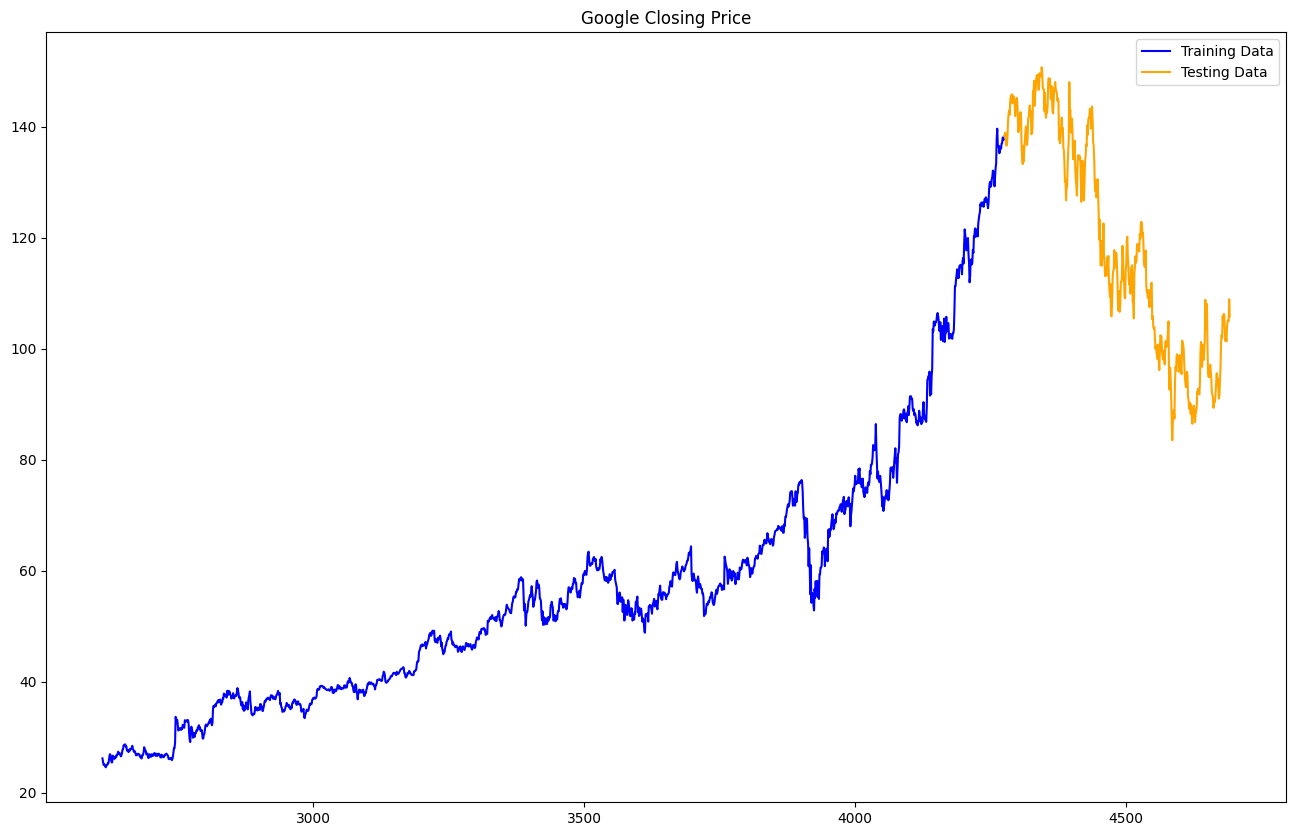

In [14]:
plt.figure(figsize= (16,10))
plt.title('Google Closing Price')
plt.plot(train_close,color= 'blue', label= 'Training Data')
plt.plot(test_close,color= 'orange', label= 'Testing Data')
plt.legend()
plt.show()

In [15]:
# Convert dataframes to arrays
train_close_arr = train_close.values
test_close_arr = test_close.values

# Initialize lists with training data and predictions
history_close = [x for x in train_close_arr]
pred_close = []

# Iterate through test data and make predictions
for t in range(len(test_close_arr)):
    # Fit ARIMA model on training data
    arima_close = ARIMA(history_close, order=(1, 1, 1))
    model_close = arima_close.fit()
    
    # Make forecast and update lists
    output_close = model_close.forecast()
    prediction_close = output_close[0]
    pred_close.append(prediction_close)
    obs = test_close_arr[t]
    history_close.append(obs)

# Calculate MSE and R2 score for model
mse_close = mean_squared_error(test_close_arr, pred_close)
r2_score_close = r2_score(test_close_arr, pred_close)
print('MSE of ARIMA model for closing price:', mse_close, '\nR2 Score of ARIMA model for closing price:', r2_score_close)

MSE of ARIMA model for closing price: 6.58102160323075 
R2 Score of ARIMA model for closing price: 0.9831143764521402


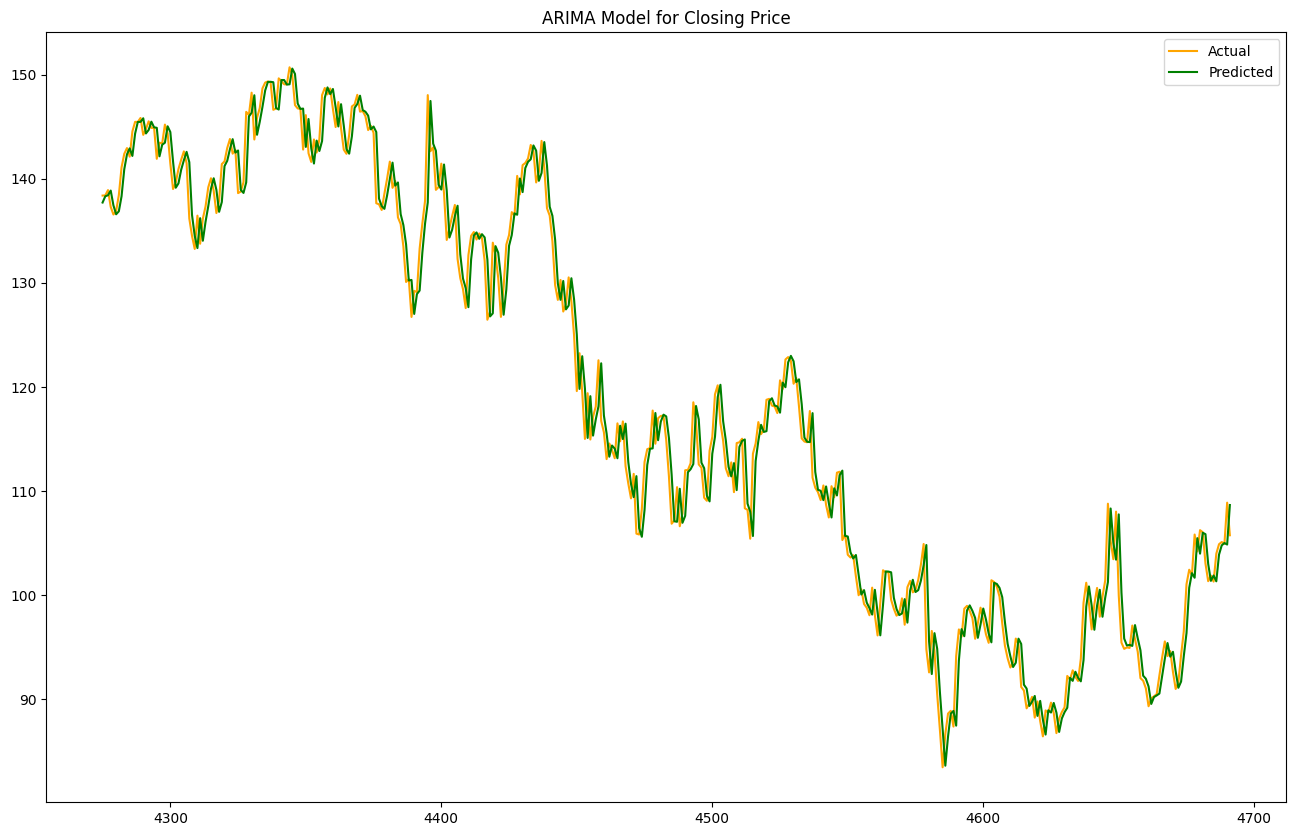

In [16]:
# Plot the prediction and real data

plt.figure(figsize= (16,10))
plt.title('ARIMA Model for Closing Price')
plt.plot(test_close.index, test_close, color= 'orange', label= 'Actual')
plt.plot(test_close.index, pred_close, color= 'green', label= 'Predicted')
plt.legend()
plt.show()

In [17]:
# Compare test data and the prediction

close_data_test = pd.DataFrame({'Closing Price (Test Data)': test_close, 'Closing Price (Prediction on Test Data)': pred_close, 'Difference': np.abs(test_close - pred_close)})
close_data_test

,Closing Price (Test Data),Closing Price (Prediction on Test Data),Difference
4275,138.389496,137.719954,0.669542
4276,138.406006,138.323477,0.082529
4277,138.916000,138.421232,0.494768
4278,137.300507,138.869635,1.569129
4279,136.570007,137.447581,0.877573
...,...,...,...
4687,104.910004,103.912178,0.997826
4688,105.120003,104.800170,0.319833
4689,104.949997,105.022870,0.072873
4690,108.900002,104.879438,4.020564


### ARIMA for Closing Price Change

In [18]:
change = data['Close Change']

Since the closing price change is calculated by subtracting the current value to the previous value, it is possible that d = 0 and p = q = 1 based on the parameters of the moedl for closing price. Let's check if (1,0,1) is the right order.

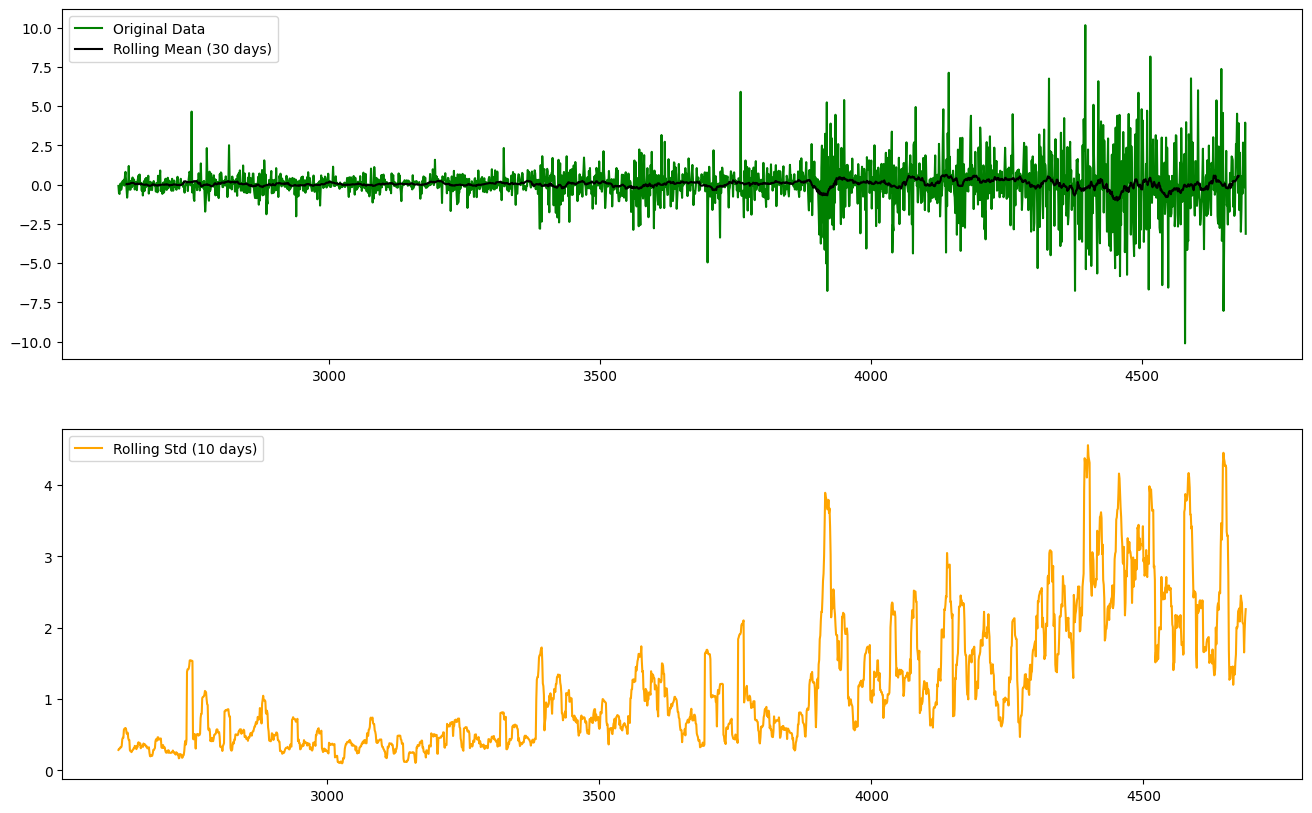

Dickey-Fuller test results

ADF Statistic: -11.004527986396322
p-value: 6.554671851700599e-20
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [19]:
stationarity_check(change)

C:\Users\Admins\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


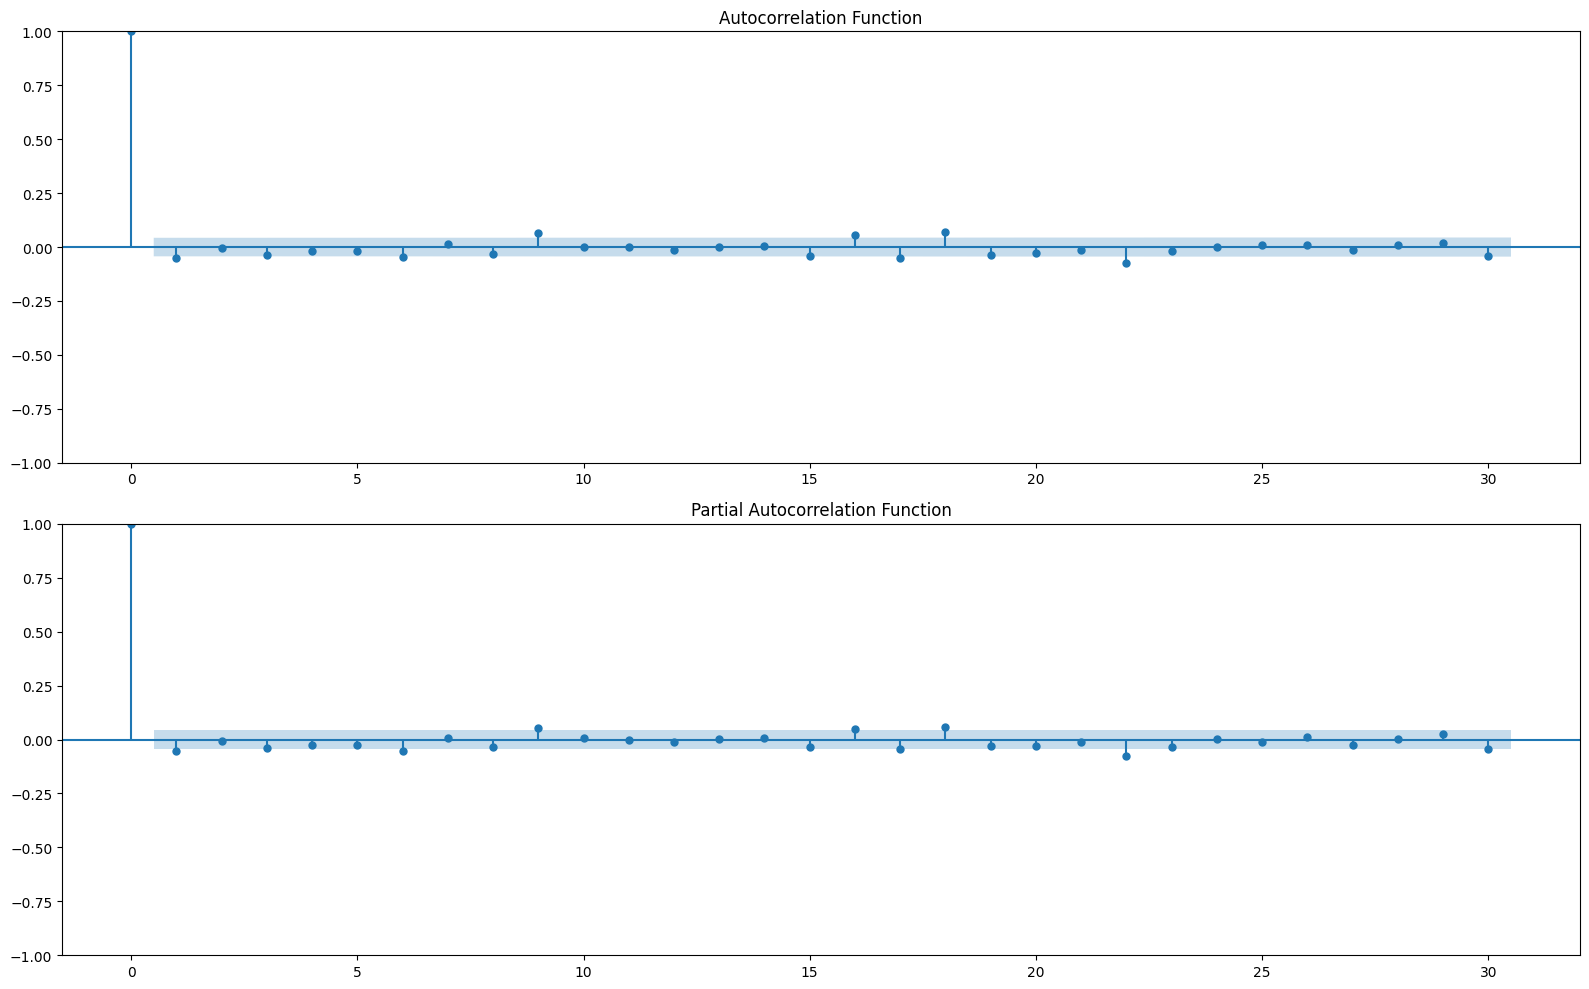

In [20]:
fig, ax = plt.subplots(2, figsize= (16, 10))
plot_acf(change, ax= ax[0], lags= 30)
ax[0].set(title= 'Autocorrelation Function')
plot_pacf(change, ax= ax[1], lags= 30)
ax[1].set(title= 'Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

In [21]:
auto_arima(change, seasonal= False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=7486.026, Time=2.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7491.406, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=7488.190, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=7488.105, Time=0.12 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=7487.336, Time=0.52 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=7487.306, Time=0.68 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=7486.204, Time=2.39 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=7491.282, Time=0.45 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=7485.667, Time=0.41 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=7489.937, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=7490.074, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=7485.505, Time=1.29 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7488.516, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7488.613, Time=0.25 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True)

The final order is (1,0,1). Let's begin applying the model.

In [22]:
# Split data into train and test data

train_change, test_change = train_test_split(change, test_size= 0.2, shuffle= False)

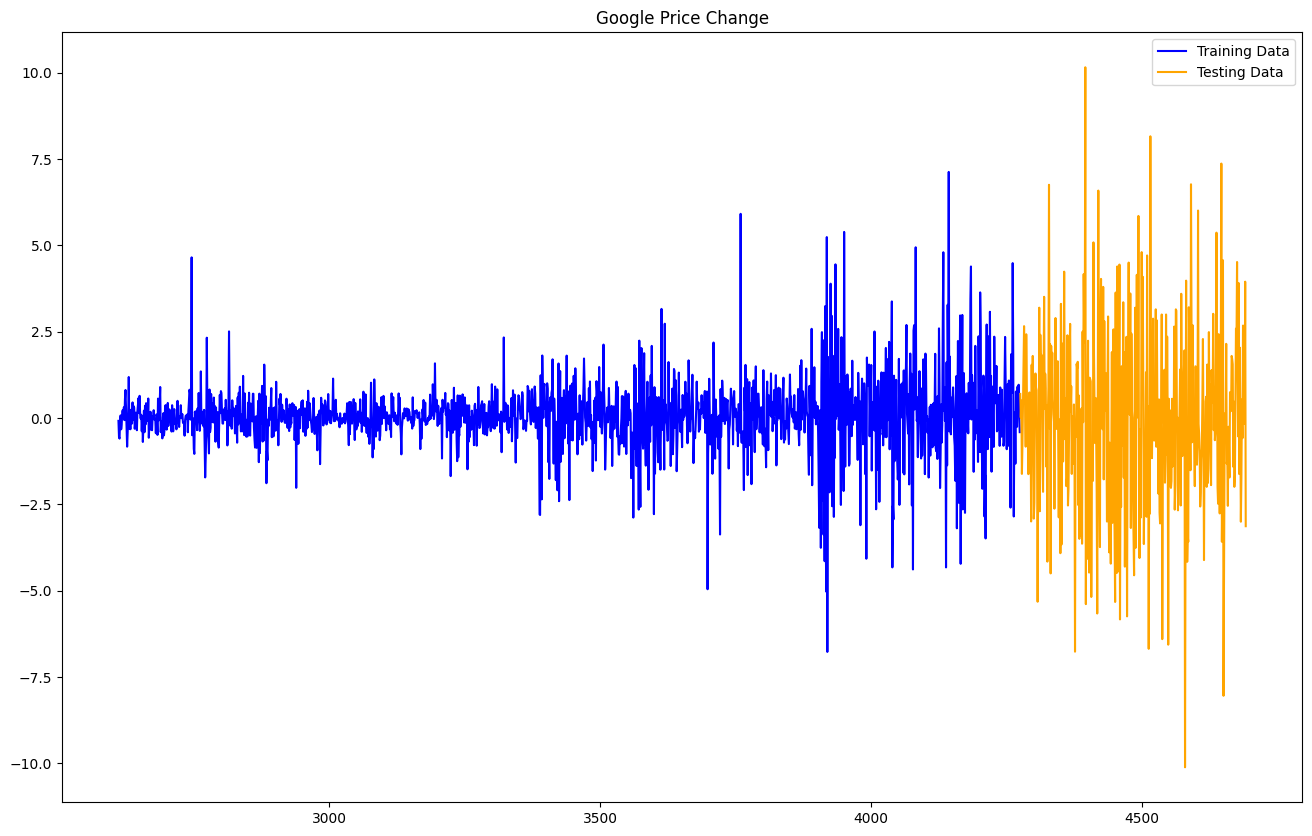

In [23]:
plt.figure(figsize=(16,10))
plt.title('Google Price Change')
plt.plot(train_change,color= 'blue', label='Training Data')
plt.plot(test_change,color= 'orange', label='Testing Data')
plt.legend()
plt.show()

In [24]:
# Convert dataframes to arrays
train_change_arr = train_change.values
test_change_arr = test_change.values

# Initialize lists with training data and predictions
history_change = [x for x in train_change_arr]
pred_change = []

# Iterate through test data and make predictions
for t in range(len(test_change_arr)):
    # Fit ARIMA model on training data
    arima_change = ARIMA(history_change, order= (1,0,1))
    model_change = arima_change.fit()

    # Make forecast and update lists
    output_change = model_change.forecast()
    prediction_change = output_change[0]
    pred_change.append(prediction_change)
    obs_change = test_change_arr[t]
    history_change.append(obs_change)

# Calculate MSE and R2 score for model
mse_change = mean_squared_error(test_change_arr, pred_change)
r2_score_change = r2_score(test_change_arr, pred_change)
print('MSE of ARIMA model for price change:', mse_change, '\nR2 Score of ARIMA model for price change:', r2_score_change)

MSE of ARIMA model for price change: 6.595956465264931 
R2 Score of ARIMA model for price change: -0.006526411302118396


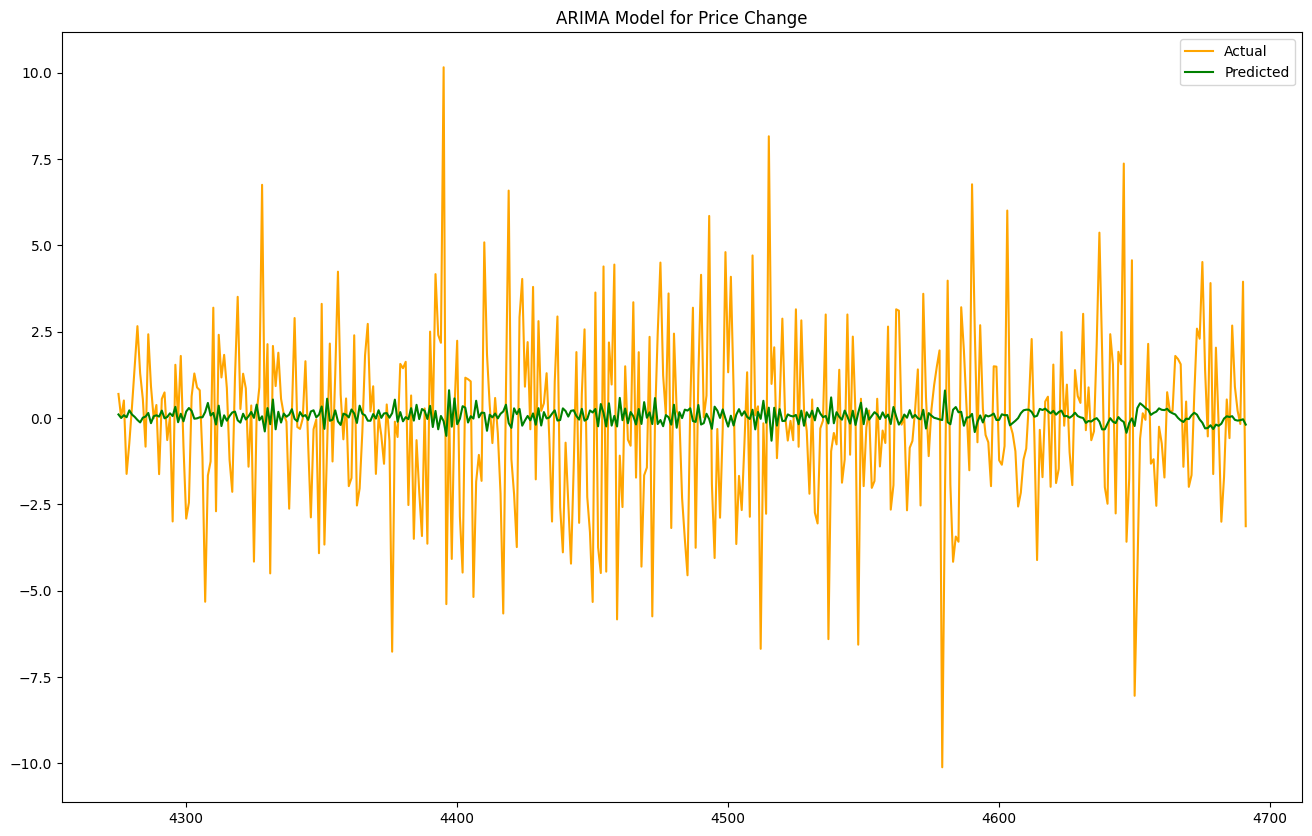

In [25]:
# Plot the prediction and real data

plt.figure(figsize= (16,10))
plt.title('ARIMA Model for Price Change')
plt.plot(test_change.index, test_change, color= 'orange', label= 'Actual')
plt.plot(test_change.index, pred_change, color= 'green', label= 'Predicted')
plt.legend()
plt.show()

In [26]:
# Compare test data and the prediction

change_data_test = pd.DataFrame({'Price Change (Test Data)': test_change, 'Price Change (Prediction on Test Data)': pred_change})
change_data_test


,Price Change (Test Data),Price Change (Prediction on Test Data)
4275,0.699997,0.105529
4276,0.016510,0.003595
4277,0.509995,0.085016
4278,-1.615494,0.024861
4279,-0.730499,0.224443
...,...,...
4687,0.910004,-0.050919
4688,0.209999,-0.072230
4689,-0.170006,-0.059973
4690,3.950005,-0.033910
